In this notebook we will see a really simplified version of the first inception network: GoogLeNet.

Thanks to an efficient use of the convolutional layers GoogLeNet managed to winner the ILSSVRC 2014 challenge achieving a top-five error rate below 7%.

The network implemented below is far from the original design. Nevertheless, it is an interesting ecample of a non linear architecture. 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Get the data

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train_full, x_test = x_train_full/255., x_test/255.

In [3]:
from sklearn.model_selection import train_test_split
x_train, x_val,  y_train, y_val  = train_test_split(x_train_full, y_train_full)

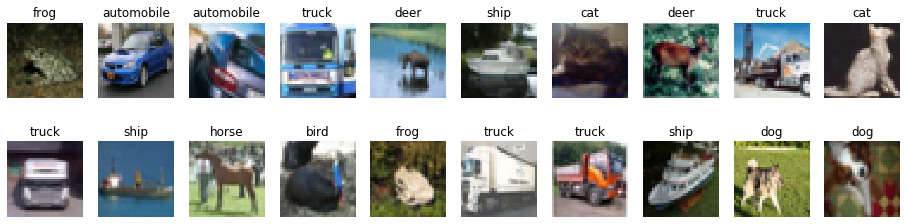

In [4]:
from utils import display_gallery

labels_map = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck'])
display_gallery(x_train[:20], labels_map[y_train[:,0]])

# The Inception module
Original paper [here](https://arxiv.org/pdf/1409.4842v1.pdf).
### Define the module

In [5]:
from tensorflow.keras.layers import Input, Dense, Concatenate, Conv2D, MaxPooling2D, AveragePooling2D, Flatten

def inception_module(inputs, n_filters=64):
    v = Conv2D(n_filters, 1, activation="relu", padding="same")(inputs)
    x = Conv2D(n_filters, 1, activation="relu", padding="same")(inputs)
    x = Conv2D(n_filters, 3, activation="relu", padding="same")(x)
#     y = Conv2D(n_filters, 1, activation="relu", padding="same")(inputs)
#     y = Conv2D(n_filters, 5, activation="relu", padding="same")(y)
    z = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding="same")(inputs)
    z = Conv2D(n_filters, 1, activation="relu", padding="same")(z)
    return Concatenate()([v, x, z])

inputs = Input(shape=[32,32,3])
module = tf.keras.Model(inputs=[inputs], outputs=inception_module(inputs))

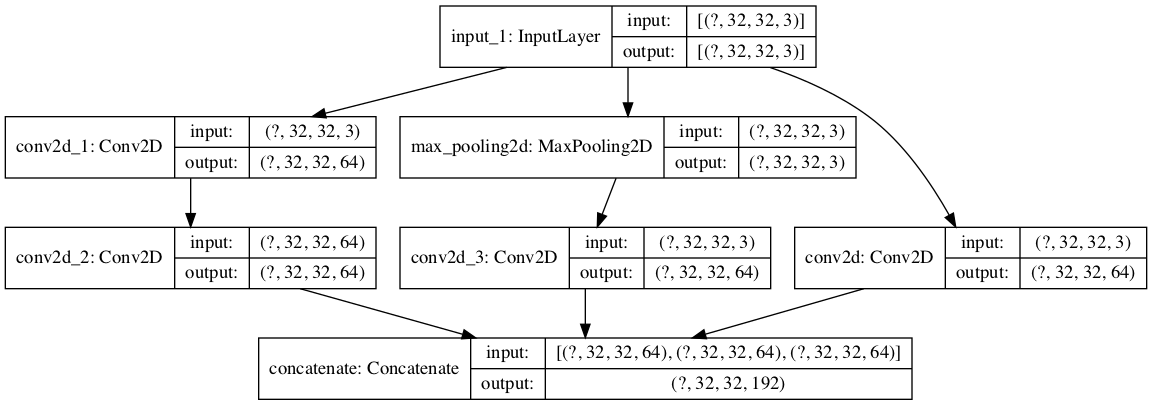

In [6]:
tf.keras.utils.plot_model(module, show_shapes=True)

In [7]:
module.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   256         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   256         input_1[0][0]                    
______________________________________________________________________________________________

### Stack modules

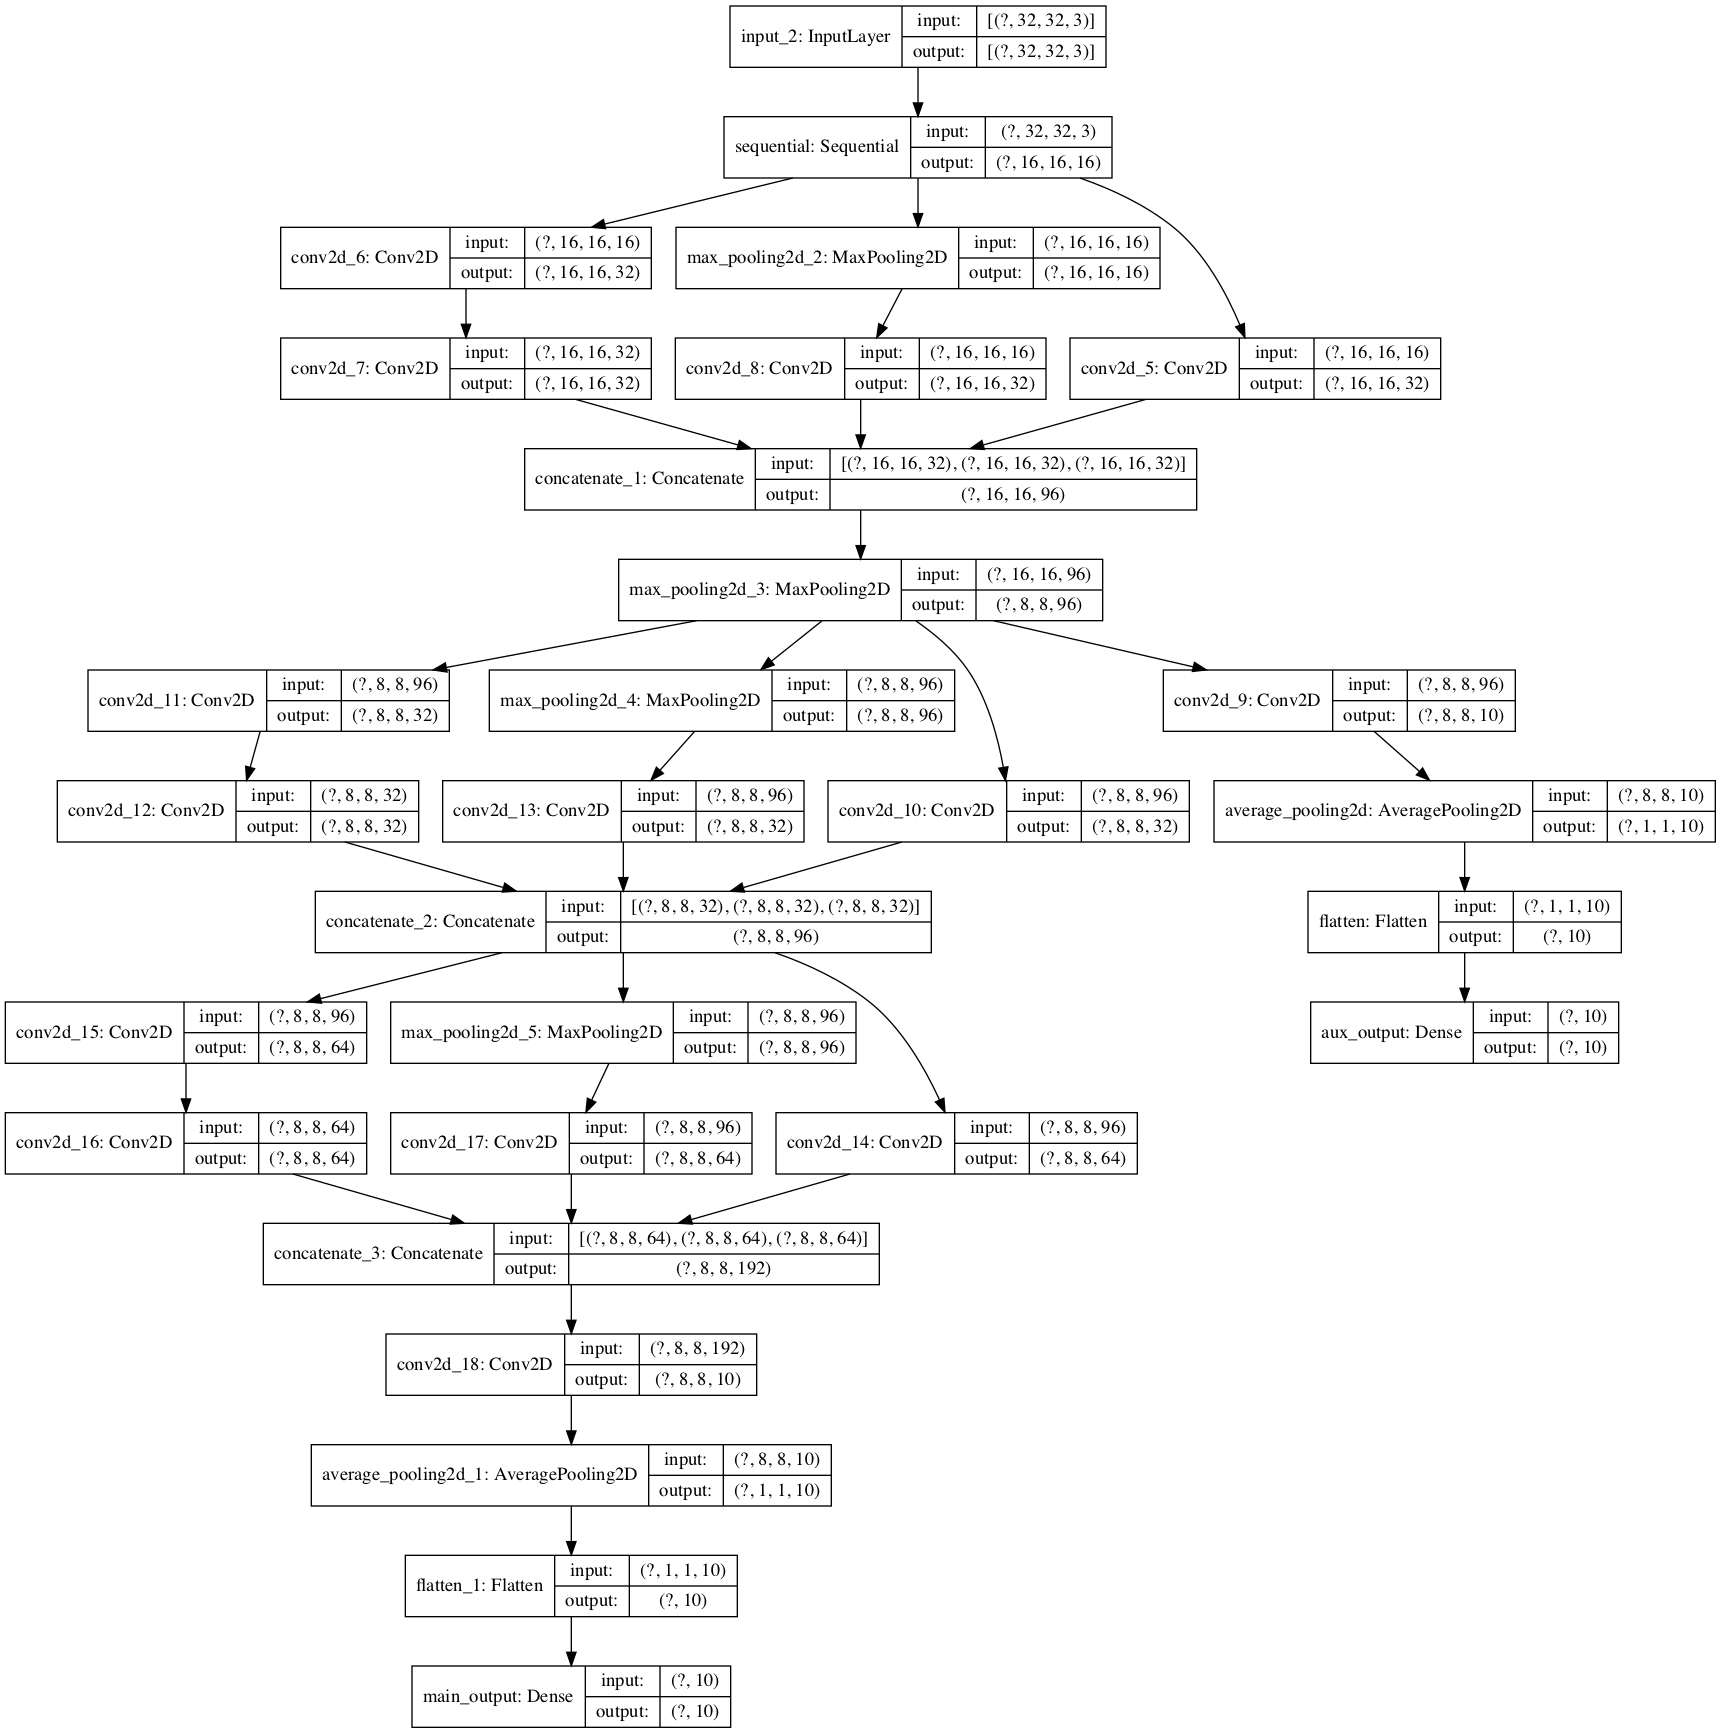

In [8]:
first_stack = tf.keras.Sequential([Conv2D(16, 5, activation="relu", padding="same"),
                                   MaxPooling2D(pool_size=(3,3), strides=(2, 2), padding="same")])
inputs = Input(shape=[32,32,3])
x = first_stack(inputs)
x = inception_module(x, 32)
x = MaxPooling2D(pool_size=(3,3), strides=(2, 2), padding="same")(x)

aux_out = Conv2D(10, 1, activation="relu", padding="same")(x)
aux_out = AveragePooling2D(pool_size=(8,8))(aux_out)
aux_out = Flatten()(aux_out)
aux_out = Dense(10, activation='softmax', name="aux_output")(aux_out)

for n_filters in [32, 64]:
    x = inception_module(x, n_filters)
    
out = Conv2D(10, 1, activation="relu", padding="same")(x)
out = AveragePooling2D(pool_size=(8,8))(out)
out = Flatten()(out)
out = Dense(10, activation='softmax', name="main_output")(out)

model = tf.keras.Model(inputs=[inputs], outputs=[aux_out, out])
tf.keras.utils.plot_model(model, show_shapes=True)

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 16, 16, 16)   1216        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 16, 16, 32)   544         sequential[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 16)   0           sequential[0][0]                 
____________________________________________________________________________________________

In [10]:
model.compile(loss={"aux_output": 'sparse_categorical_crossentropy',
                    "main_output": 'sparse_categorical_crossentropy'},
              loss_weights={"aux_output": 0.3, "main_output": 0.7},
              optimizer="RMSProp",
              metrics=["accuracy"])

In [11]:
model.fit(x=x_train, y=[y_train, y_train], batch_size=32, epochs=5, validation_data=(x_val, (y_val, y_val)))

Epoch 1/5
1172/1172 [==============================] - 56s 48ms/step - loss: 2.0231 - aux_output_loss: 2.0748 - main_output_loss: 2.0010 - aux_output_accuracy: 0.2107 - main_output_accuracy: 0.2471 - val_loss: 1.8958 - val_aux_output_loss: 1.9509 - val_main_output_loss: 1.8721 - val_aux_output_accuracy: 0.2550 - val_main_output_accuracy: 0.3078
Epoch 2/5
1172/1172 [==============================] - 71s 61ms/step - loss: 1.6568 - aux_output_loss: 1.8198 - main_output_loss: 1.5869 - aux_output_accuracy: 0.3015 - main_output_accuracy: 0.4118 - val_loss: 1.6028 - val_aux_output_loss: 1.7533 - val_main_output_loss: 1.5383 - val_aux_output_accuracy: 0.3217 - val_main_output_accuracy: 0.4226
Epoch 3/5
1172/1172 [==============================] - 61s 52ms/step - loss: 1.4965 - aux_output_loss: 1.7077 - main_output_loss: 1.4060 - aux_output_accuracy: 0.3496 - main_output_accuracy: 0.4858 - val_loss: 1.5177 - val_aux_output_loss: 1.7333 - val_main_output_loss: 1.4253 - val_aux_output_accuracy: 0

In [12]:
model.evaluate(x_test, (y_test, y_test))

313/313 [==============================] - 3s 9ms/step - loss: 1.2609 - aux_output_loss: 1.5187 - main_output_loss: 1.1504 - aux_output_accuracy: 0.4348 - main_output_accuracy: 0.5842


[1.2609199285507202,
 1.518703579902649,
 1.1504415273666382,
 0.43479999899864197,
 0.5842000246047974]

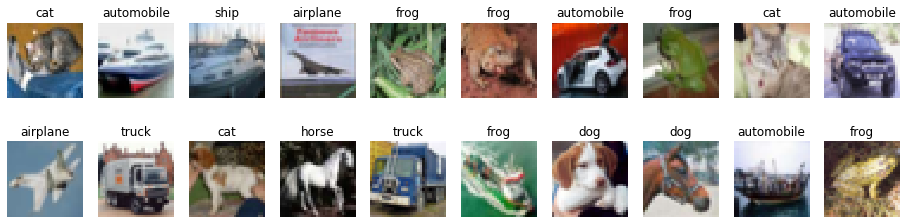

In [13]:
y_aux, y_pred = model.predict(x_test[:20])
display_gallery(x_test[:20], labels_map[np.argmax(y_pred, axis=1)])